In [1]:
import pickle

with open('data_small_1000_20000', 'rb') as f:
    lattices = pickle.load(f)

import numpy as np

random_coords = np.load('data_small_1000_random_coords_20000.npy')
data_params = np.load('data_params_1000_20000.npy')
    
from progressbar import ProgressBar

pbar = ProgressBar()

for ___ in pbar(range(100000)):
    import numpy as np
    np.set_printoptions(precision=4)

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        plt = None

    try:
        from mpl_toolkits.mplot3d import Axes3D
    except ImportError:
        Axes3D = None

    from pyntcloud.plot.common import get_colors


    def set_proper_aspect_ratio(ax):
        extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
        sz = extents[:,1] - extents[:,0]
        centers = np.mean(extents, axis=1)
        maxsize = max(abs(sz))
        r = maxsize/2
        for ctr, dim in zip(centers, 'xyz'):
            getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)


    def plot_with_matplotlib(cloud, **kwargs):

        colors = get_colors(cloud, kwargs["use_as_color"], kwargs["cmap"])

        ptp = cloud.xyz.ptp()

        plt.figure(figsize=(10, 10))
        ax = plt.axes(projection='3d')
        ax.view_init(elev=kwargs["elev"], azim=kwargs["azim"])

        ax.scatter(
            cloud.xyz[:, 0],
            cloud.xyz[:, 1],
            cloud.xyz[:, 2],
            marker="o",
            facecolors=colors / 255,
            zdir="z",
            depthshade=True,
            s=kwargs["initial_point_size"] or ptp / 10)
        ax._axis3don = False
        set_proper_aspect_ratio(ax)
        plt.savefig('fig_{}_azim_{:.4f}_elev_{:.4f}_N_lifetime={}.png'.format(np.log(kwargs["walk_params"]), 
                                                                              kwargs["azim"], 
                                                                              kwargs["elev"], 
                                                                              int(kwargs["N_lifetime"])))
        plt.close()
        return None

    import os

    import numpy as np

    import pandas as pd

    from pyntcloud.structures.base import StructuresDict
    from pyntcloud.filters import ALL_FILTERS
    from pyntcloud.io import FROM_FILE, TO_FILE, FROM_INSTANCE, TO_INSTANCE
    from pyntcloud.neighbors import k_neighbors, r_neighbors
    from pyntcloud.plot import DESCRIPTION, AVAILABLE_BACKENDS
    from pyntcloud.plot.threejs_backend import plot_with_threejs
    from pyntcloud.plot.pythreejs_backend import plot_with_pythreejs
    from pyntcloud.plot.pyvista_backend import plot_with_pyvista
    from pyntcloud.samplers import ALL_SAMPLERS
    from pyntcloud.scalar_fields import ALL_SF
    from pyntcloud.structures import ALL_STRUCTURES
    from pyntcloud.utils.dataframe import convert_columns_dtype


    class MyPyntCloud(object):
        """A Pythonic Point Cloud."""

        def __init__(self, points, mesh=None, structures=None, **kwargs):
            """Create PyntCloud.

            Parameters
            ----------
            points: pd.DataFrame
                DataFrame of N rows by M columns.
                Each row represents one point of the point cloud.
                Each column represents one scalar field associated to its corresponding point.

            mesh: pd.DataFrame or None, optional
                Default: None
                Triangular mesh associated with points.

            structures: dict, optional
                Map key(base.Structure.id) to val(base.Structure)

            kwargs: custom attributes
            """
            self.points = points
            self.mesh = mesh
            self.structures = StructuresDict()
            structures = structures or {}
            for key, val in structures.items():
                self.structures[key] = val
            for key, val in kwargs.items():
                setattr(self, key, val)
            # store raw xyz values to share memory along structures
            self.xyz = self.points[["x", "y", "z"]].values
            self.centroid = self.xyz.mean(0)

        def __repr__(self):
            default = [
                "_PyntCloud__points",
                "_PyntCloud__mesh",
                "structures",
                "xyz",
                "centroid"
            ]
            others = ["\n\t {}: {}".format(x, str(type(getattr(self, x))))
                      for x in self.__dict__ if x not in default]

            if self.mesh is None:
                n_faces = 0
            else:
                n_faces = len(self.mesh)

            return DESCRIPTION.format(
                len(self.points), len(self.points.columns) - 3,
                n_faces,
                self.structures.n_kdtrees,
                self.structures.n_voxelgrids,
                self.centroid[0], self.centroid[1], self.centroid[2],
                "".join(others))

        @property
        def points(self):
            return self.__points

        @points.setter
        def points(self, df):
            if not isinstance(df, pd.DataFrame):
                raise TypeError("Points argument must be a DataFrame")
            elif not set(['x', 'y', 'z']).issubset(df.columns):
                raise ValueError("Points must have x, y and z coordinates")
            self._update_points(df)

        @property
        def mesh(self):
            return self.__mesh

        @mesh.setter
        def mesh(self, df):
            # allow PyntCloud to don't have mesh assigned
            if df is not None:
                if not isinstance(df, pd.DataFrame):
                    raise TypeError("Mesh argument must be a DataFrame")
                elif not set(['v1', 'v2', 'v3']).issubset(df.columns):
                    print(df.columns)
                    raise ValueError(
                        "Mesh must have v1, v2 and v3 columns, at least")
                self.__mesh = df
            else:
                self.__mesh = None

        @classmethod
        def from_file(cls, filename, **kwargs):
            """Extract data from file and construct a PyntCloud with it.

            Parameters
            ----------
            filename: str
                Path to the file from which the data will be read

            kwargs: only usable in some formats

            Returns
            -------
            PyntCloud: object
                PyntCloud instance, containing all valid elements in the file.
            """
            ext = filename.split(".")[-1].upper()
            if ext not in FROM_FILE:
                raise ValueError(
                    "Unsupported file format; supported formats are: {}".format(list(FROM_FILE)))
            else:
                return cls(**FROM_FILE[ext](filename, **kwargs))

        @classmethod
        def from_instance(cls, library, instance, **kwargs):
            """Convert library's instance to PyntCloud intstance.

            Parameters
            ----------
            library: str
                Name of the library of the instance to be converted from.
            instance:
                `library's` instance
            kwargs: only usable in some formats

            Returns
            -------
            PyntCloud: object
                PyntCloud instance, containing all valid elements in the file.
            """
            library = library.upper()
            if library not in FROM_INSTANCE:
                raise ValueError(
                    "Unsupported library; supported libraries are: {}".format(list(FROM_INSTANCE)))
            else:
                return cls(**FROM_INSTANCE[library](instance, **kwargs))

        def to_file(self, filename, also_save=None, **kwargs):
            """Save PyntCloud data to file.

            Parameters
            ----------
            filename: str
                Path to the file from which the data will be read

            also_save: list of str, optional
                Default: None
                Names of the attributes that will be extracted from the PyntCloud
                to be saved in addition to points. Usually also_save=["mesh"]

            kwargs: only usable in some formats
            """
            convert_columns_dtype(self.points, np.float64, np.float32)
            ext = filename.split(".")[-1].upper()
            if ext not in TO_FILE:
                raise ValueError(
                    "Unsupported file format; supported formats are: {}".format(list(TO_FILE)))
            kwargs["filename"] = filename
            kwargs["points"] = self.points
            if also_save is not None:
                for x in also_save:
                    kwargs[x] = getattr(self, x)

            TO_FILE[ext](**kwargs)

        def to_instance(self, library, **kwargs):
            """Convert PyntCloud's instance to library's instance.

            Parameters
            ----------
            library: str
                Name of the library of the instance to be converted to.

            kwargs: only usable in some formats
            """
            convert_columns_dtype(self.points, np.float64, np.float32)
            library = library.upper()
            if library not in TO_INSTANCE:
                raise ValueError(
                    "Unsupported library; supported linraries are: {}".format(list(TO_INSTANCE)))

            return TO_INSTANCE[library](self, **kwargs)

        def add_scalar_field(self, name, **kwargs):
            """Add one or multiple columns to PyntCloud.points.

            Parameters
            ----------
            name: str
                One of the available names. See below.
            kwargs
                Vary for each name. See below.

            Returns
            -------
            sf_added: list of str
                The name of each of the columns (scalar fields) added.
                Useful for chaining operations that require string names.

            Notes
            -----

            Available scalar fields are:

            **REQUIRE EIGENVALUES**

                ARGS
                    ev: list of str
                        ev = self.add_scalar_field("eigen_values", ...)

                sphericity

                anisotropy

                linearity

                omnivariance

                eigenentropy

                planarity

                eigen_sum

                curvature

            **REQUIRE K_NEIGHBORS**

                ARGS
                    k_neighbors: (N, k) ndarray
                        Returned from: self.get_neighbors(k, ...) /
                        manually querying some self.kdtrees[x] /
                        other methods.

                eigen_decomposition

                eigen_values

            **REQUIRE NORMALS**

                orientation_degrees

                orientation_radians

                inclination_radians

                inclination_degrees

            **REQUIRE RGB**

                hsv

                relative_luminance

                rgb_intensity


            **REQUIRE VOXELGRID**

                ARGS
                    voxelgrid_id: VoxelGrid.id
                        voxelgrid_id = self.add_structure("voxelgrid", ...)

                voxel_x

                voxel_y

                voxel_n

                voxel_z

                euclidean_clusters


            **ONLY REQUIRE XYZ**

                plane_fit
                    max_dist: float, optional
                        Default: 1e-4
                        Maximum distance from point to model in order to be considered as inlier.
                    max_iterations: int, optional (Default 100)
                        Maximum number of fitting iterations.

                sphere_fit
                    max_dist: float, optional
                        Default: 1e-4
                        Maximum distance from point to model in order to be considered as inlier.
                    max_iterations: int, optional
                        Default: 100
                        Maximum number of fitting iterations.

                custom_fit
                    model: subclass of ransac.models.RansacModel
                        Model to be fitted
                    sampler: subclass of ransac.models.RansacSampler
                        Sample method to be used
                    name: str
                        Will be used to name the added column
                    model_kwargs: dict, optional
                        Default: {}
                        Will be passed to single_fit function.
                    sampler_kwargs: dict, optional
                        Default: {}
                        Will be passed to single_fit function.

                spherical_coords
                    degrees: bool, optional
                        Default: True.
                        Return polar and azimuthal angles in degrees.
            """
            if name in ALL_SF:
                scalar_field = ALL_SF[name](pyntcloud=self, **kwargs)
                scalar_field.extract_info()
                scalar_field.compute()
                scalar_fields_added = scalar_field.get_and_set()

            else:
                raise ValueError("Unsupported scalar field. Check docstring")

            return scalar_fields_added

        def add_structure(self, name, **kwargs):
            """Build a structure and add it to the corresponding PyntCloud's attribute.

            Parameters
            ----------
            name: str
                One of the available names. See below.
            kwargs
                Vary for each name. See below.

            Returns
            -------
            structure.id: str
                Identification string associated with the added structure.
                Useful for chaining operations that require string names.

            Notes
            -----
            Available structures are:

            **ONLY REQUIRE XYZ**

                kdtree
                    leafsize: int, optional
                        Default: 16
                        The number of points at which the algorithm switches over to brute-force.
                        Has to be positive.

                voxelgrid
                    x_y_z: list of int, optional
                        Default: [2, 2, 2]
                        The number of segments in which each axis will be divided.
                        x_y_z[0]: x axis
                        x_y_z[1]: y axis
                        x_y_z[2]: z axis
                        If sizes is not None it will be ignored.
                    sizes: list of float, optional
                        Default: None
                        The desired voxel size along each axis.
                        sizes[0]: voxel size along x axis.
                        sizes[1]: voxel size along y axis.
                        sizes[2]: voxel size along z axis.
                    bb_cuboid: bool, optional
                        Default: True
                        If True, the bounding box of the point cloud will be adjusted
                        in order to have all the dimensions of equal length.

                octree
                    TODO

            """
            if name in ALL_STRUCTURES:
                info = ALL_STRUCTURES[name].extract_info(pyntcloud=self)
                structure = ALL_STRUCTURES[name](**info, **kwargs)
                structure.compute()
                structure_added = structure.get_and_set(self)

            else:
                raise ValueError("Unsupported structure. Check docstring")

            return structure_added

        def get_filter(self, name, and_apply=False, **kwargs):
            """Compute filter over PyntCloud's points and return it.

            Parameters
            ----------
            name: str
                One of the available names. See below.

            and_apply: boolean, optional
                Default: False
                If True, filter will be applied to self.points

            kwargs
                Vary for each name. See below.

            Returns
            -------
            filter: boolean array
                Boolean mask indicating wherever a point should be keeped or not.
                The size of the boolean mask will be the same as the number of points
                in the pyntcloud.

            Notes
            -----

            Available filters are:

            **REQUIRE KDTREE**

                ARGS
                    kdtree : KDTree.id
                        kdtree = self.add_structure("kdtree", ...)

                ROR    (Radius Outlier Removal)
                    k: int
                        Number of neighbors that will be used to compute the filter.
                    r: float
                        The radius of the sphere with center on each point. The filter
                        will look for the required number of neighboors inside that sphere.

                SOR    (Statistical Outlier Removal)
                    k: int
                        Number of neighbors that will be used to compute the filter.
                    z_max: float
                        The maximum Z score which determines if the point is an outlier.

            **ONLY REQUIRE XYZ**

                BBOX    (Bounding Box)
                    min_i, max_i: float
                        The bounding box limits for each coordinate. If some limits are missing,
                        the default values are -infinite for the min_i and infinite for the max_i.

            """
            if name in ALL_FILTERS:
                pointcloud_filter = ALL_FILTERS[name](pyntcloud=self, **kwargs)
                pointcloud_filter.extract_info()
                boolean_array = pointcloud_filter.compute()

                if and_apply:
                    self.apply_filter(boolean_array)

                return boolean_array

            else:
                raise ValueError("Unsupported filter. Check docstring")

        def get_sample(self, name, as_PyntCloud=False, **kwargs):
            """Return arbitrary number of points sampled by selected method.

            Parameters
            ----------
            name: str
                One of the available names.
                See below.

            as_PyntCloud: bool, optional
                Default: False
                If True, sampled points will be returned as PyntCloud instance.

            kwargs
                Vary for each name.
                See below.

            Returns
            -------
            sampled_points: (n, 3) ndarray or PyntCloud
                'n' vary for each method. PyntCloud if as_PyntCloud

            Notes
            -----

            Available sampling methods are:

            **REQUIRE MESH**

                mesh_random
                    n: int
                        Number of points to be sampled.
                    rgb: bool, optional
                        Default: False
                        Indicates if rgb values will be also sampled
                    normals: bool, optional
                        Default: False
                        Indicates if normals will be also sampled

            **REQUIRE VOXELGRID**

                ARGS
                    voxelgrid: VoxelGrid.id
                        voxelgrid = self.add_structure("voxelgrid", ...)

                voxelgrid_centers

                voxelgrid_centroids

                voxelgrid_nearest
                    n: int
                        Number of nearest point per voxel to sample

                voxelgrid_highest


            **USE POINTS**

                points_random
                    n: int
                        Number of points to be sampled.
            """
            if name in ALL_SAMPLERS:
                sample.extract_info()
                sample = sampler.compute()

                if as_PyntCloud:
                    return PyntCloud(sample)

                return sample

            else:
                raise ValueError("Unsupported sampling method. Check docstring")

        def get_neighbors(self, k=None, r=None, kdtree=None):
            """For each point finds the indices that compose its neighborhood.

            Parameters
            ----------
            k: int, optional
                Default: None
                For "K-nearest neighbor" search.
                Number of nearest neighbors that will be used to build the neighborhood.

            r: float, optional
                Default: None
                For "Fixed-radius neighbors" search.
                Radius of the sphere that will be used to build the neighborhood.

            kdtree: str, optional
                Default: None
                KDTree.id in self.structures.

                - If **kdtree** is None:

                The KDTree will be computed and added to PyntCloud as part of the process.

                - Else:

                The given KDTree will be used for neighbor search.

            Returns
            -------
            neighbors: array-like
                (N, k) ndarray if k is not None.
                    Indices of the 'k' nearest neighbors for the 'N' points.
                (N,) ndarray of lists if r is not None.
                    Array holding a variable number of indices corresponding
                    to the neighbors with distance < r.
            """
            if kdtree is None:
                kdtree_id = self.add_structure("kdtree")
                kdtree = self.structures[kdtree_id]
            else:
                kdtree = self.structures[kdtree]

            if k is not None:
                return k_neighbors(kdtree, k)

            elif r is not None:
                return r_neighbors(kdtree, r)

            else:
                raise ValueError("You must supply 'k' or 'r' values.")

        def get_mesh_vertices(self, rgb=False, normals=False):
            """Decompose triangles of self.mesh from vertices in self.points.

            Returns
            -------
            v1, v2, v3: ndarray
                (N, 3) arrays of vertices so v1[i], v2[i], v3[i] represent the ith triangle
            """
            use_columns = ["x", "y", "z"]
            if rgb:
                use_columns.extend(["red", "green", "blue"])
            if normals:
                use_columns.extend(["nx", "ny", "nz"])

            points = self.points[use_columns].values

            v1 = points[self.mesh["v1"].values]
            v2 = points[self.mesh["v2"].values]
            v3 = points[self.mesh["v3"].values]

            return v1, v2, v3

        def apply_filter(self, boolean_array):
            """Update self.points removing points where filter is False.

            Parameters
            ----------
            boolean_array: ndarray, dtype bool
                len(boolean array) must be equal to len(self.points)
            """
            self.points = self.points.loc[boolean_array].reset_index(drop=True)

        def split_on(self, scalar_field, and_return=False, save_format="ply", save_path=os.getcwd()):
            """Divide the PyntCloud using unique values in given sf.

            This function will generate PyntClouds by grouping points using the unique
            values found in the given scalar field.

            Parameters
            ----------
            scalar_field: str
                Name of the scalar field to be used for splitting.

            and_return: boolean, optional
                Default: False
                If True, return a list with the splits.

            save_format: str, optional
                Default: "ply"
                Extension used to save the generated PyntClouds.
                Must be of one of the formats present in pyntcloud.io.TO

            save_path: str, optional
                Default: "."
                Path where the PyntClouds will be saved.
            """
            scalar_field = self.points[scalar_field]

            splits = {x: PyntCloud(self.points.loc[scalar_field == x]) for x in scalar_field.unique()}

            if not os.path.exists(save_path):
                os.makedirs(save_path)

            for key, val in splits.items():
                val.to_file("{}/{}.{}".format(save_path, key, save_format))

            if and_return:
                return splits

        def _update_points(self, df):
            """Utility function. Implicitly called when self.points is assigned."""
            self.mesh = None
            self.structures = StructuresDict()
            self.__points = df
            self.xyz = self.__points[["x", "y", "z"]].values
            self.centroid = self.xyz.mean(0)

        def plot(
                self,
                backend=None,
                scene=None,
                width=800,
                height=500,
                background="black",
                mesh=False,
                use_as_color=["red", "green", "blue"],
                initial_point_size=None,
                cmap="hsv",
                polylines=None,
                linewidth=5,
                return_scene=False,
                output_name="pyntcloud_plot",
                elev=0.,
                azim=90.,
                **kwargs
        ):

            """Visualize a PyntCloud  using different backends.

            Parameters
            ----------
            backend: {"pythreejs", "threejs", "pyvista", "matplotlib"}, optional
                Default: "pythreejs"
                Used to select one of the available libraries for plotting.

            width: int, optional
                Default: 800

            height: int, optional
                Default: 500

            background: str, optional
                Default: "black"
                Used to select the default color of the background.
                In some backends, i.e "pythreejs" the background can be dynamically changed.

            use_as_color: str or ["red", "green", "blue"], optional
                Default: ["red", "green", "blue"]
                Indicates which scalar fields will be used to colorize the rendered
                point cloud.

            initial_point_size: the initial size of each point in the rendered point cloud.
                Can be adjusted after rendering using slider.

            cmap: str, optional
                Default: "hsv"
                Color map that will be used to convert a single scalar field into rgb.
                Check matplotlib cmaps.

            return_scene: bool, optional
                Default: False.
                Used with "pythreejs" backend in order to return the pythreejs.Scene object

            polylines: list of dict, optional
                Default None.
                List of dictionaries defining polylines with the following syntax:
                polylines=[
                    {
                        "color": "0xFFFFFF",
                        "vertices": [[0, 0, 0], [0, 0, 1]]
                    },
                    {           {
                        "color": "red",
                        "vertices": [[0, 0, 0], [0, 0, 1], [0, 2, 0]
                    }
                ]
            elev: float
                Elevation angle in the z plane. Used for matplotlib
            azim: float
                Azimuth angle in the x,y plane.
            """
            args = locals()
            args.update(kwargs)
            backend = args.pop("backend")

            # Choose fisrt avaialable backend
            if backend is None and len(AVAILABLE_BACKENDS) > 0:
                backend = AVAILABLE_BACKENDS[0]
            elif backend is None:
                backend = 'pythreejs'

            # Plot with backend of choice
            if backend == "matplotlib":
                return plot_with_matplotlib(self, **args)
            elif backend == "pythreejs":
                return plot_with_pythreejs(self, **args)
            elif backend == "threejs":
                return plot_with_threejs(self, **args)
            elif backend == "pyvista":
                return plot_with_pyvista(self, **args)
            else:
                raise NotImplementedError("{} backend is not supported".format(backend))

    import numpy as np
    import pandas as pd
    from pyntcloud import PyntCloud

    def get_point_cloud_input_from_lattice_elements(lattice_elements):
        coords = list(lattice_elements.keys())
        vals = list(lattice_elements.values())
        coords = [list(coords[_]) for _ in range(len(coords)) if (vals[_] == 0)]
        coords = np.array(coords)
        return coords

    def sc(x):
        return np.log(1+x)
    sc = np.vectorize(sc)
    
    INDEX_OF_LATTICE = np.random.randint(0, len(lattices))

    ttt_initial = get_point_cloud_input_from_lattice_elements(lattices[INDEX_OF_LATTICE]).astype(np.float32)
    ttt = np.concatenate([ttt_initial+np.random.normal(0, 0.27, ttt_initial.shape) for _ in range(100)])

    points = pd.DataFrame(
        ttt.astype(np.float32), 
        columns=['x', 'y', 'z'])

    elev = np.random.uniform(0, 360)
    azim = np.random.uniform(0, 360)

    cloud = MyPyntCloud(points)
    k_neighbors = cloud.get_neighbors(k=500)
    eigenvalues = cloud.add_scalar_field(
        "eigen_values", 
        k_neighbors=k_neighbors)
    sphericity = cloud.add_scalar_field("sphericity", ev=eigenvalues)
    cloud.plot(use_as_color=sphericity, 
               cmap="plasma", 
               backend='matplotlib', 
               elev=elev, 
               azim=azim, 
               initial_point_size=5, 
               walk_params=random_coords[INDEX_OF_LATTICE], N_lifetime=data_params[INDEX_OF_LATTICE][-1])

ERROR:root:Internal Python error in the inspect module.                       |
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\deeplearning\envs\PythonGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-f81e845752e3>", line 875, in <module>
    walk_params=random_coords[INDEX_OF_LATTICE], N_lifetime=data_params[INDEX_OF_LATTICE][-1])
  File "<ipython-input-1-f81e845752e3>", line 826, in plot
    return plot_with_matplotlib(self, **args)
  File "<ipython-input-1-f81e845752e3>", line 66, in plot_with_matplotlib
    int(kwargs["N_lifetime"])))
  File "C:\deeplearning\envs\PythonGPU\lib\site-packages\matplotlib\pyplot.py", line 723, in savefig
    fig.canvas.draw_idle()   # need this if 'transparent=True' to reset colors
  File "C:\deeplearning\envs\PythonGPU\lib\site-packages\matplotlib\backend_bases.py", line 1907, in draw_idle
    self.draw(*args, **kwargs)
  File "C:\deeplearning\envs\PythonGPU\lib\site-packages\matplotlib\backends\backend_agg.py", line 388, i

KeyboardInterrupt: 

In [1]:
import numpy as np
data_params = np.load('data_params_1000_20000.npy')

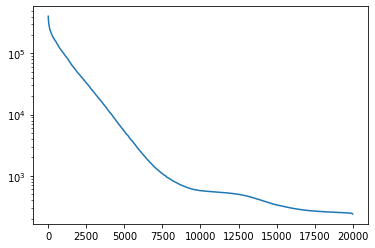

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.sort(data_params[:,2])[::-1])
plt.yscale('log')

In [3]:
images = ! dir phase_images

In [4]:
len(images)

97426